# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [14]:
 # define your regions here
presel = {
        "mu": {
            "met": "met_pt<20",
        },
        "ele": {
            "met": "met_pt<20",            
        },
}


channels = ["ele", "mu"]
samples = [
    "QCD",
    "Data",
    "DYJets",
    "WJetsLNu",
]

years = ["2016", "2016APV", "2017", "2018"]
# years = ["2017"]

samples_dir = {
#     "2018": "../eos/May16_fakes_2018",
#     "2017": "../eos/May16_fakes_2017",
#     "2016": "../eos/May16_fakes_2016",
#     "2016APV": "../eos/May16_fakes_2016APV",
    
    # new jobs
    "2018": "../eos/May31_fakes_2018",
    "2017": "../eos/May31_fakes_2017",
    "2016": "../eos/May31_fakes_2016",
    "2016APV": "../eos/May31_fakes_2016APV",
}

In [21]:
from make_stacked_hists import make_events_dict

events_dict = make_events_dict(years, channels, samples_dir, samples, presel)

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Finding SingleMuon_Run2016H samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016G samples and should combine them under Data
INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 1048 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 493 events
INFO:root:tot event weight 27.941337429313222 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying met selection on 5497 events
INFO:root:Will fill the Data dataframe with the remaining 2900 events
INFO:root:tot event weight 2900.0 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 832 events
INFO:root:Will fill the WJetsLNu da

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:Applying met selection on 481 events
INFO:root:Will fill the DYJets dataframe with the remaining 243 events
INFO:root:tot event weight 0.09240198918474968 

INFO:root:Finding SingleElectron_Run2016F samples and should combine them under Data
INFO:root:Finding QCD_Pt_120to170 samples and should combine them under QCD
INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying met selection on 3629 events
INFO:root:Will fill the DYJets dataframe with the remaining 2038 events
INFO:root:tot event weight 74.23925071301112 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under DYJets
INFO:root:Applying met selection on 493 events
INFO:root:Will fill the DYJets dataframe with the remaining 255 events
INFO:root:tot event wei

INFO:root:Will fill the QCD dataframe with the remaining 987 events
INFO:root:tot event weight 2606.5281519272785 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:Applying met selection on 4276 events
INFO:root:Will fill the DYJets dataframe with the remaining 2353 events
INFO:root:tot event weight 11.06424422503385 

INFO:root:Finding SingleMuon_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:Applying met selection on 217 events
INFO:root:Will fill the QCD dataframe with the remaining 114 events
INFO:root:tot event weight 11394.540720696143 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 1132 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 561 eve

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 89 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 33 events
INFO:root:tot event weight 0.04012627532344276 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:Applying met selection on 689 events
INFO:root:Will fill the QCD dataframe with the remaining 374 events
INFO:root:tot event weight 6.056415633443338 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:Applying met selection on 102 events
INFO:root:Will fill the DYJets dataframe with the remaining 57 events
INFO:root:tot event weight 11.921905056518721 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 1376 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 681 events
INFO:root:tot event weight 393.7582021

INFO:root:Applying met selection on 414 events
INFO:root:Will fill the QCD dataframe with the remaining 212 events
INFO:root:tot event weight 211.93353194717548 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:Applying met selection on 22 events
INFO:root:Will fill the QCD dataframe with the remaining 12 events
INFO:root:tot event weight 0.025626922503936382 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 3337 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1561 events
INFO:root:tot event weight 99.10402195903772 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:Applying met selection on 1870 events
INFO:root:Will fill the WJetsLN

INFO:root:Applying met selection on 1631 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 827 events
INFO:root:tot event weight 389.43990128061733 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under DYJets
INFO:root:Applying met selection on 1308 events
INFO:root:Will fill the DYJets dataframe with the remaining 697 events
INFO:root:tot event weight 0.4479820934886205 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying met selection on 4389 events
INFO:root:Will fill the DYJets dataframe with the remaining 2454 events
INFO:root:tot event weight 165.30670750335958 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Applying met selection on 6442 events
INFO:root:Will fill the Data dataframe with the remaining 3335 events
INFO:root:tot event weight 3335.

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:Applying met selection on 2 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:Applying met selection on 177 events
INFO:root:Will fill the QCD dataframe with the remaining 95 events
INFO:root:tot event weight 1.9482600491498303 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:Applying met selection on 335 events
INFO:root:Will fill the QCD dataframe with the remaining 173 events
INFO:root:tot event weight 73.9769313586635 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:Applying met selection on 318 events
INFO:root:Will fill the QCD dataframe with the remaining 163 events
INFO:root:tot event weight 3009.599231442371 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and 

In [22]:
events_dict["2017"]["ele"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'Data', 'QCD'])

# Stacked hists

In [23]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [24]:
for key in events_dict["2017"]["ele"]["Data"].keys():
    print(key)

N_tight_lep
N_loose_lep
tight_lep1_pt
tight_lep1_eta
tight_lep2_pt
tight_lep2_eta
mll_tight
loose_lep1_pt
loose_lep1_eta
loose_lep2_pt
loose_lep2_eta
mll_loose
met_pt
NumFatjets
lep_fj_dr
fj_pt
fj_eta
fj_phi
mT_tight1
mT_loose1
xsecweight
nominal


In [25]:
vars_to_plot = [
#     "N_tight_lep",
#     "N_loose_lep",
    "tight_lep1_pt",
    "tight_lep1_eta",
#     "tight_lep2_pt",
#     "tight_lep2_eta",
#     "mll_tight",
    "loose_lep1_pt",
    "loose_lep1_eta",
#     "loose_lep2_pt",
#     "loose_lep2_eta",
#     "mll_loose",
    "met_pt",
#     "mT_loose1",
#     "mT_tight1",
]

samples_to_plot = [
    "QCD",
    "Data",
    "DYJets",
    "WJetsLNu",    
]

In [29]:
import utils

# axis_dict = {
#     "mll_loose": hist2.axis.Regular(40, 30, 450, name="var", label=r"Zmass [GeV]", overflow=True),
#     "fj_pt": hist2.axis.Regular(30, 250, 600, name="var", label=r"Higgs candidate jet $p_T$ [GeV]", overflow=True),

#     "loose_lep1_pt": hist2.axis.Regular(40, 30, 400, name="var", label=r"First loose Lepton $p_T$ [GeV]", overflow=True),    
#     "loose_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"First loose Lepton |$\eta$|", overflow=True),    
    
#     "loose_lep2_pt": hist2.axis.Regular(40, 30, 200, name="var", label=r"Second loose Lepton $p_T$ [GeV]", overflow=True),
#     "loose_lep2_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Second loose Lepton |$\eta$|", overflow=True),

#     "tight_lep1_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"First tight Lepton $p_T$ [GeV]", overflow=True),    
#     "tight_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"First tight Lepton |$\eta$|", overflow=True),    
    
#     "tight_lep2_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"Second tight Lepton $p_T$ [GeV]", overflow=True),
#     "tight_lep2_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Second tight Lepton |$\eta$|", overflow=True),
    
#     "met_pt": hist2.axis.Regular(40, 0, 30, name="var", label=r"MET [GeV]", overflow=True),
    
    
#     "mT_loose1": hist2.axis.Regular(40, 0, 100, name="var", label=r"mT (using loose lepton)", overflow=True),
#     "mT_tight1": hist2.axis.Regular(40, 0, 100, name="var", label=r"mT (using tight lepton) [GeV]", overflow=True),
    
# }


axis_dict = {
    "ele": {
        "loose_lep1_pt": hist2.axis.Regular(40, 30, 400, name="var", label=r"Loose electron $p_T$ [GeV]", overflow=True),    
        "loose_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Loose electron |$\eta$|", overflow=True),    

        "tight_lep1_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"Tight electron $p_T$ [GeV]", overflow=True),    
        "tight_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Tight electron |$\eta$|", overflow=True),

        "met_pt": hist2.axis.Regular(40, 0, 20, name="var", label=r"MET [GeV]", overflow=True),
        
    },
    "mu": {
        "loose_lep1_pt": hist2.axis.Regular(40, 30, 400, name="var", label=r"Loose muon $p_T$ [GeV]", overflow=True),    
        "loose_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Loose muon |$\eta$|", overflow=True),    

        "tight_lep1_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"Tight muon $p_T$ [GeV]", overflow=True),    
        "tight_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Tight muon |$\eta$|", overflow=True),
        
        "met_pt": hist2.axis.Regular(40, 0, 20, name="var", label=r"MET [GeV]", overflow=True),
    }
}


presel = {
    "fake": f"loose_lep1_pt>0",   # dummy
}


years = ["2016", "2016APV", "2017", "2018"]
# years = ["2017"]

ch = "ele"

# fill histograms
hists = {}

for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        axis_dict[ch][var],
        storage=hist2.storage.Weight(),            
    )        

    for sample in samples_to_plot:
        for year in years:

            df = events_dict[year][ch][sample]

            for region in presel:
                df = df.query(presel[region])

            if "eta" in var:
                x = np.absolute(df[var])
            else:
                x = df[var]
            w = df["nominal"]

            if sample!="QCD":
                x = x[w<100]
                w = w[w<100]                

            hists[var].fill(
                samples=sample,
                var=x,
                weight=w,
            )     

for var in vars_to_plot:
    fix_neg_yields(hists[var])

Will plot tight_lep1_pt histogram
#bins: 20, chi_square: 135.612, reduced_chi_square: 7.137
Will plot tight_lep1_eta histogram
#bins: 25, chi_square: nan, reduced_chi_square: nan


../python/utils.py:595: RuntimeWarning: invalid value encountered in divide
  chi_square = ((obs_ratio - exp_ratio) ** 2 / sigma**2).sum()


Will plot loose_lep1_pt histogram
#bins: 40, chi_square: 235.525, reduced_chi_square: 6.039
Will plot loose_lep1_eta histogram
#bins: 25, chi_square: nan, reduced_chi_square: nan


../python/utils.py:595: RuntimeWarning: invalid value encountered in divide
  chi_square = ((obs_ratio - exp_ratio) ** 2 / sigma**2).sum()


Will plot met_pt histogram
#bins: 40, chi_square: 77.019, reduced_chi_square: 1.975


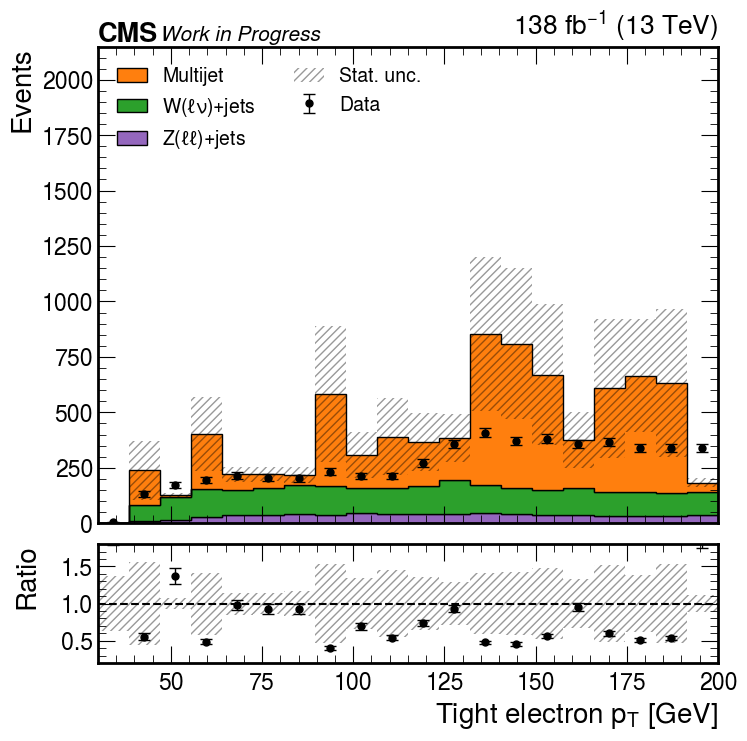

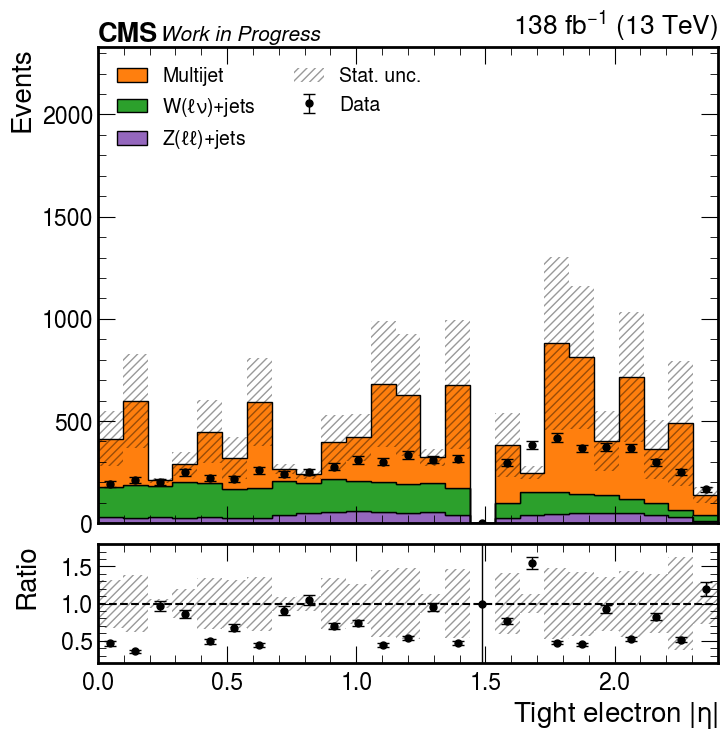

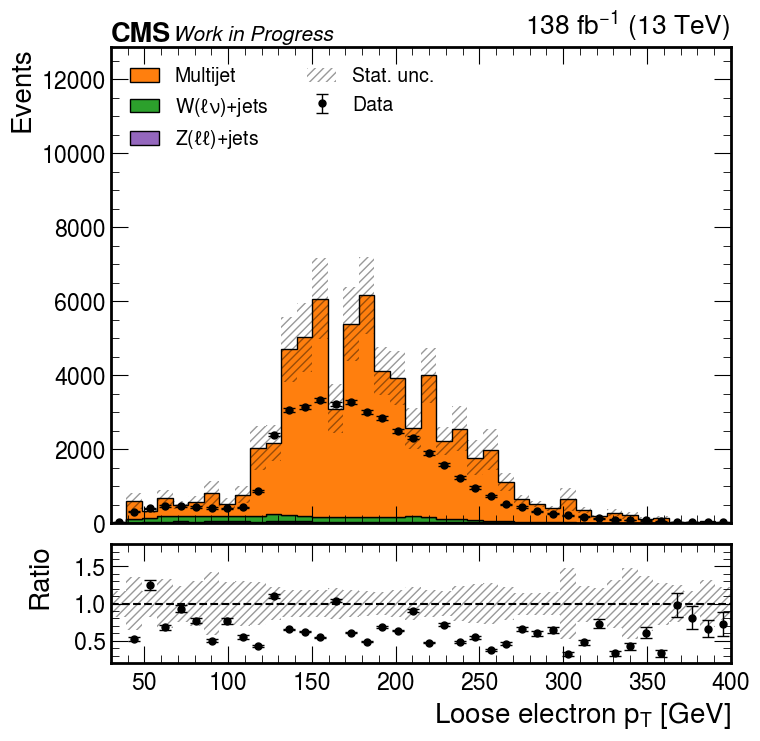

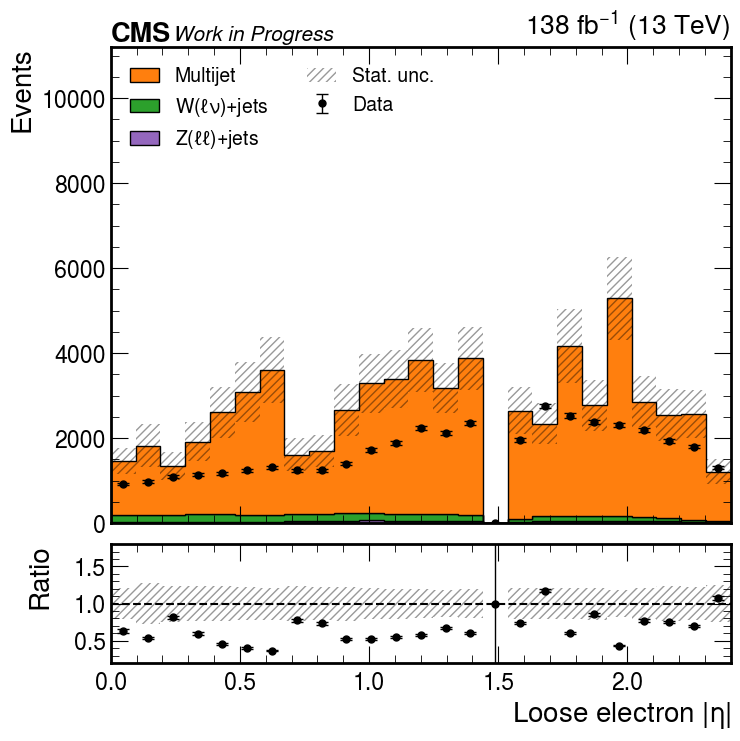

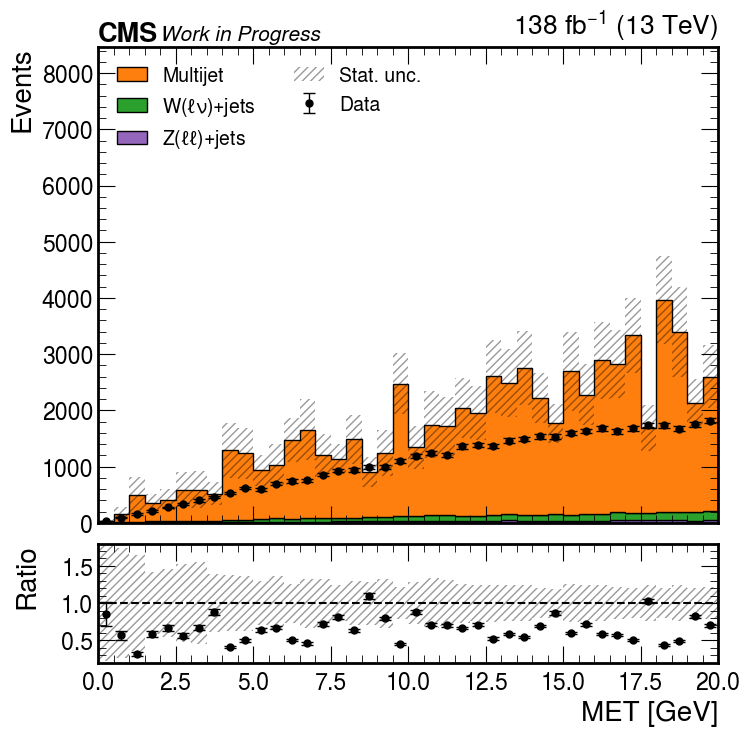

In [30]:
plt.rcParams.update({"font.size": 20})
add_data = True
add_soverb = False
    
from utils import plot_hists as plot_hists

if len(years)>1:
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/{ch}_Run2"
else:
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/{ch}_{year}"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            mult=1,
            outpath=PATH,
#             text_=text_,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=False,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )

In [31]:
def set_im_title(year, ch, region):
    if region != "SF":
        region += " rate"
    if ch == "ele":
        return f"Electron {region} {year}"
    else:
        return f"Muon {region} {year}"
    
    
lab_var_dict = {
    "FR_Nominal": "nominal",
    "FR_stat_Up": "FR stat. unc. Up",
    "FR_stat_Down": "FR stat. unc. Down",
    "EWK_SF_Up": "EWK SF stat. unc. Up",
    "EWK_SF_Down": "EWK SF stat. unc. Down",
}
    
def plot_matrix(M, region, channels, UNC=None, title=None):
    for ch in channels:
        fig, ax = plt.subplots(figsize=(6,10))
        
        im = ax.imshow(M[ch], vmax=1, vmin=0)#, cmap='hot', interpolation='nearest')
        
        ax.set_xticks(ticks=np.arange(-0.5, (len(etabinning)-1), 1), labels=np.round(etabinning,2))
        ax.set_yticks(ticks=np.arange(-0.5, (len(ptbinning[ch])-1), 1), labels=np.round(ptbinning[ch],2))

        ax.tick_params(axis='x', which='major', pad=8)
        ax.tick_params(axis='y', which='major', pad=8)

        # Loop over data dimensions and create text annotations.
        for i in range(len(ptbinning[ch])-1):
            for j in range(len(etabinning)-1):
                if UNC is not None:
                    text = ax.text(j, i, str(np.round(M[ch][i, j],3)) + r" $\pm$ " + str(np.round(UNC[ch][i, j],3)), ha="center", fontsize=20)
                else:
                    text = ax.text(j, i, str(np.round(M[ch][i, j],3)), ha="center", va="center", fontsize=20)

        ax.set_xlabel(r"$\eta$")            
        ax.set_ylabel(r"$p_T$")
        
        plt.colorbar(im, shrink=0.6)
        plt.tight_layout(rect=[0, 0.04, 1, 0.85])

        if title is not None:
            ax.set_title(set_im_title(year,ch,region) + f"\n {lab_var_dict[title]}", pad=20)
        else:
            ax.set_title(set_im_title(year,ch,region), pad=20)
        plt.savefig(f"{PATH}/{year}_{ch}_{region}_{variation}.pdf")    
            
PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/"            

# Fake rate extraction

In [33]:
years

['2016', '2016APV', '2017', '2018']

In [38]:
channels = [
    "ele",
#     "mu"
]

ptbinning = {}
ptbinning["ele"] = [2000, 160,120,60, 30]
ptbinning["mu"] = [2000, 120, 90, 60, 30]

etabinning = [0, 1.4, 2.5]

In [39]:
# FR = {}
# for year in years:
#     FR[year] = {}
#     for ch in channels:
#         FR[year][ch] = np.zeros((len(ptbinning[ch])-1,len(etabinning)-1))
#         print(year, ch, FR[year][ch].shape)
        
        
SIGMA = {}
for year in years:
    SIGMA[year] = {}
    for ch in channels:
        SIGMA[year][ch] = np.zeros((len(ptbinning[ch])-1,len(etabinning)-1))
        
        
FR = {}

variations = ["FR_Nominal", "FR_stat_Up", "FR_stat_Down", "EWK_SF_Up", "EWK_SF_Down"]
for variation in variations:
    FR[variation] = {}

    for year in years:
        FR[variation][year] = {}
        for ch in channels:
            FR[variation][year][ch] = np.zeros((len(ptbinning[ch])-1,len(etabinning)-1))
            print(variation, year, ch, FR[variation][year][ch].shape)

FR_Nominal 2016 ele (4, 2)
FR_Nominal 2016APV ele (4, 2)
FR_Nominal 2017 ele (4, 2)
FR_Nominal 2018 ele (4, 2)
FR_stat_Up 2016 ele (4, 2)
FR_stat_Up 2016APV ele (4, 2)
FR_stat_Up 2017 ele (4, 2)
FR_stat_Up 2018 ele (4, 2)
FR_stat_Down 2016 ele (4, 2)
FR_stat_Down 2016APV ele (4, 2)
FR_stat_Down 2017 ele (4, 2)
FR_stat_Down 2018 ele (4, 2)
EWK_SF_Up 2016 ele (4, 2)
EWK_SF_Up 2016APV ele (4, 2)
EWK_SF_Up 2017 ele (4, 2)
EWK_SF_Up 2018 ele (4, 2)
EWK_SF_Down 2016 ele (4, 2)
EWK_SF_Down 2016APV ele (4, 2)
EWK_SF_Down 2017 ele (4, 2)
EWK_SF_Down 2018 ele (4, 2)


In [40]:
# get the SF
EWK_SF = {
   "EWK_SF_Nominal": {
        "2016": 0.700,
        "2016APV": 0.743,
        "2017": 0.880,
        "2018": 0.796,
    },
   "EWK_SF_Up": {
        "2016": 0.738,
        "2016APV": 0.780,
        "2017": 0.908,
        "2018": 0.820,
    },
   "EWK_SF_Down": {
        "2016": 0.661,
        "2016APV": 0.706,
        "2017": 0.852,
        "2018": 0.772,
    },
}


for variation in variations:

    for year in years:
        for ch in channels:
            print(f"{year}, {ch} channel:")    

            df = events_dict[year][ch]

            for i in range(len(ptbinning[ch])-1):
                high_pt = ptbinning[ch][i]
                low_pt = ptbinning[ch][i+1]

                msk_pt = (df["Data"]["loose_lep1_pt"] >= low_pt) & (df["Data"]["loose_lep1_pt"] < high_pt)
                msk_pt_wjets = (df["WJetsLNu"]["loose_lep1_pt"] >= low_pt) & (df["WJetsLNu"]["loose_lep1_pt"] < high_pt)
                msk_pt_dyjets = (df["DYJets"]["loose_lep1_pt"] >= low_pt) & (df["DYJets"]["loose_lep1_pt"] < high_pt)

                print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")

                for j in range(len(etabinning)-1):        

                    low_eta = etabinning[j]
                    high_eta = etabinning[j+1]

                    # get data tight/loose ratio                
                    msk_eta = (abs(df["Data"]["loose_lep1_eta"]) >= low_eta) & (abs(df["Data"]["loose_lep1_eta"]) < high_eta)
                    msk_Nt1 = df["Data"]["N_tight_lep"]==1
                    msk_Nt0 = df["Data"]["N_loose_lep"]==1

                    tight = len(df["Data"][msk_Nt1 & msk_pt & msk_eta])
                    loose = len(df["Data"][msk_Nt0 & msk_pt & msk_eta])            

                    # get the EWK corr WJets
                    msk_eta_wjets = (abs(df["WJetsLNu"]["loose_lep1_eta"]) >= low_eta) & (abs(df["WJetsLNu"]["loose_lep1_eta"]) < high_eta)
                    msk_Nt1_wjets = df["WJetsLNu"]["N_tight_lep"]==1      
                    msk_Nt0_wjets = df["WJetsLNu"]["N_loose_lep"]==1

                    tight_wjets = df["WJetsLNu"]["nominal"][msk_Nt1_wjets & msk_pt_wjets & msk_eta_wjets].sum()
                    loose_wjets = df["WJetsLNu"]["nominal"][msk_Nt0_wjets & msk_pt_wjets & msk_eta_wjets].sum()

                    # get the EWK corr dyjets
                    msk_eta_dyjets = (abs(df["DYJets"]["loose_lep1_eta"]) >= low_eta) & (abs(df["DYJets"]["loose_lep1_eta"]) < high_eta)
                    msk_Nt1_dyjets = df["DYJets"]["N_tight_lep"]==1      
                    msk_Nt0_dyjets = df["DYJets"]["N_loose_lep"]==1

                    tight_dyjets = df["DYJets"]["nominal"][msk_Nt1_dyjets & msk_pt_dyjets & msk_eta_dyjets].sum()
                    loose_dyjets = df["DYJets"]["nominal"][msk_Nt0_dyjets & msk_pt_dyjets & msk_eta_dyjets].sum()               

                    if (variation=="FR_Nominal") or (variation=="FR_stat_Up") or (variation=="FR_stat_Down"):
                        ewk_corr = EWK_SF["EWK_SF_Nominal"][year]
                    else:
                        ewk_corr = EWK_SF[variation][year]
                        
                    num = ( tight - ewk_corr * (tight_wjets + tight_dyjets) )
                    den = ( loose - ewk_corr * (loose_wjets + loose_dyjets) )
                    
                    FR[variation][year][ch][i,j] = num / den
                    
                    SIGMA[year][ch][i,j] = FR[variation][year][ch][i,j] * np.sqrt( (np.sqrt(num)/num)**2 + (np.sqrt(den)/den)**2 )                    

                    if (variation=="FR_stat_Up"):
                        FR[variation][year][ch][i,j] += SIGMA[year][ch][i,j]
                    
                    elif (variation=="FR_stat_Down"):
                        FR[variation][year][ch][i,j] -= SIGMA[year][ch][i,j]

#                     SIGMA[year][ch][i,j] = FR[year][ch][i,j] * np.sqrt( (np.sqrt(num)/num)**2 + (np.sqrt(den)/den)**2 )

            print("----------------------------")

2016, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.00)
   ptbin (30.00, 60.00)
----------------------------
2016APV, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.00)
   ptbin (30.00, 60.00)
----------------------------
2017, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.00)
   ptbin (30.00, 60.00)
----------------------------
2018, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.00)
   ptbin (30.00, 60.00)
----------------------------
2016, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.00)
   ptbin (30.00, 60.00)
----------------------------
2016APV, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.00)
   ptbin (30.00, 60.00)
----------------------------
2017, ele channel:
   ptbin (160.00, 2000.00)
   ptbin (120.00, 160.00)
   ptbin (60.00, 120.0

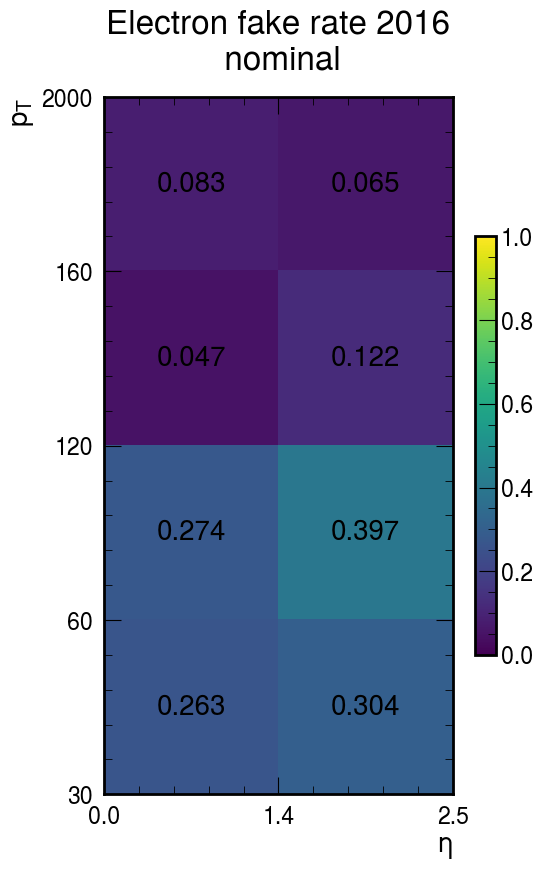

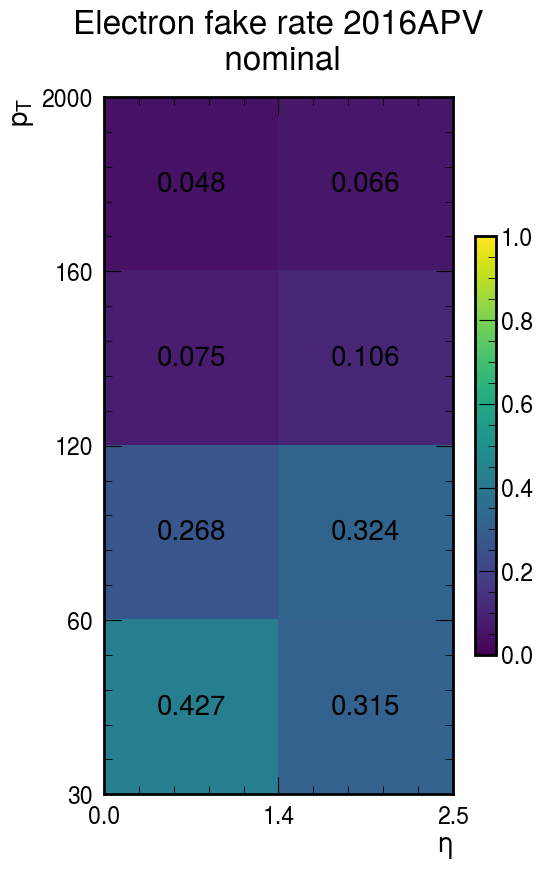

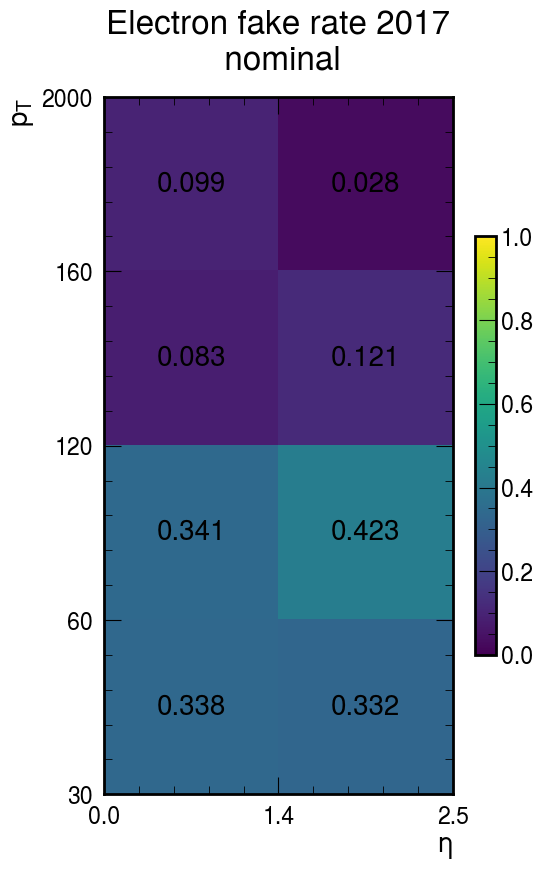

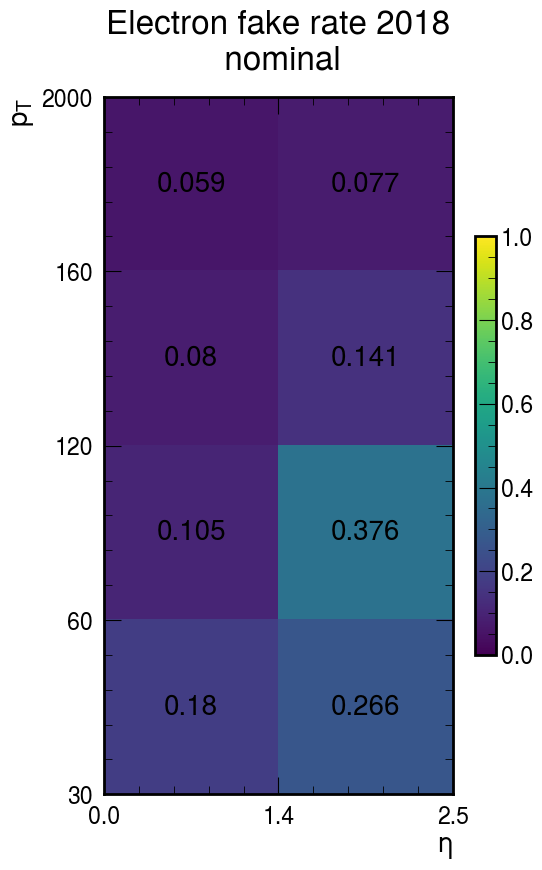

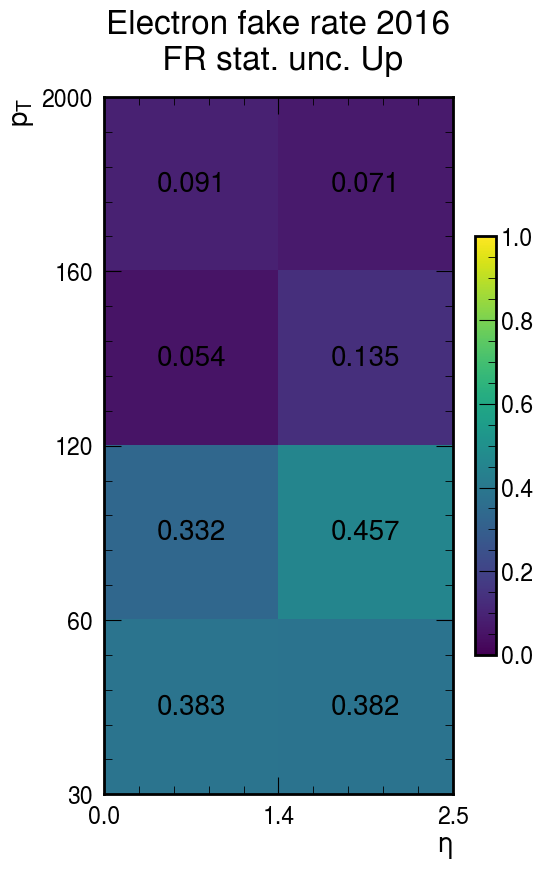

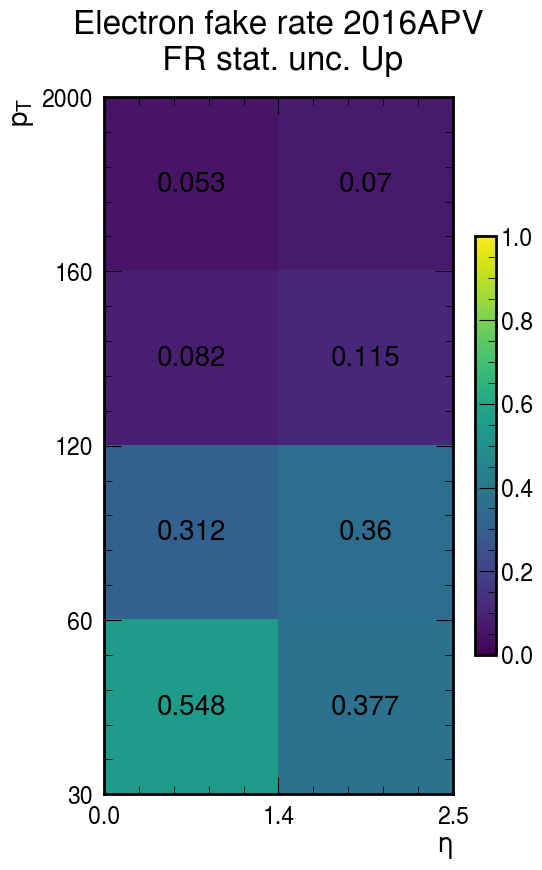

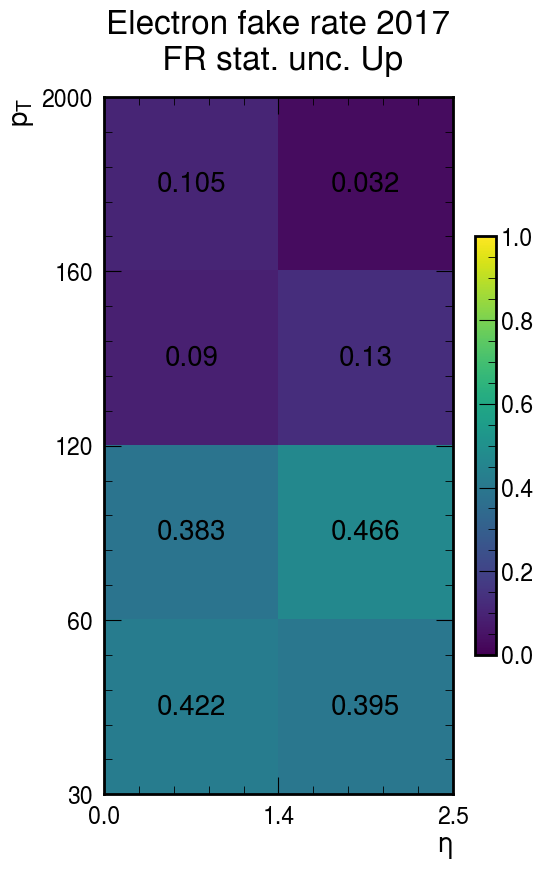

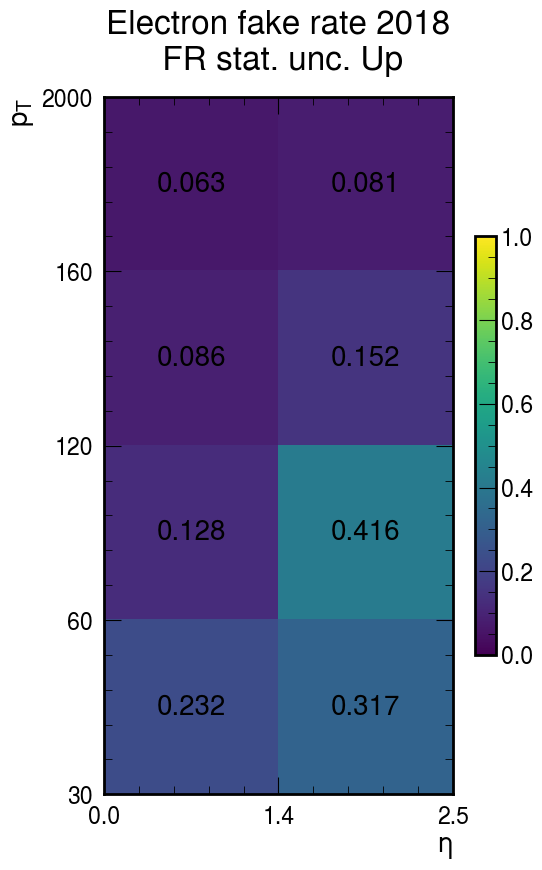

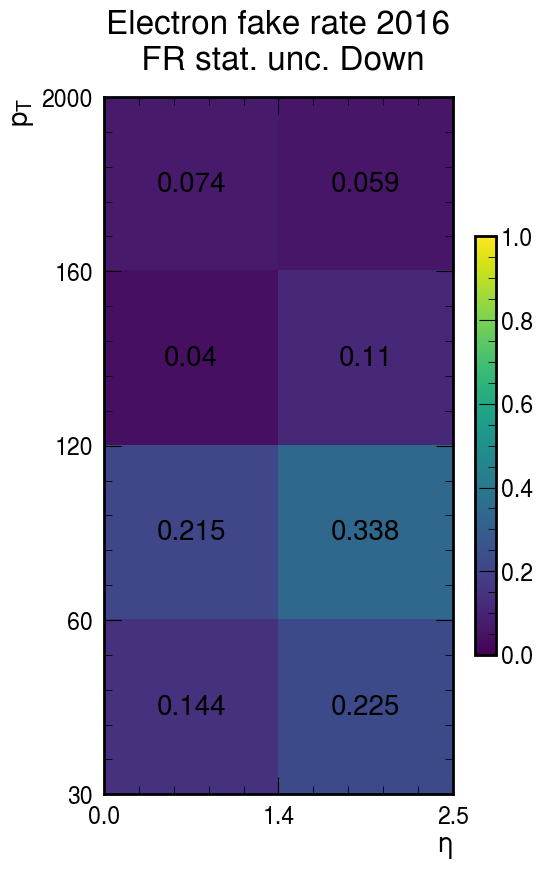

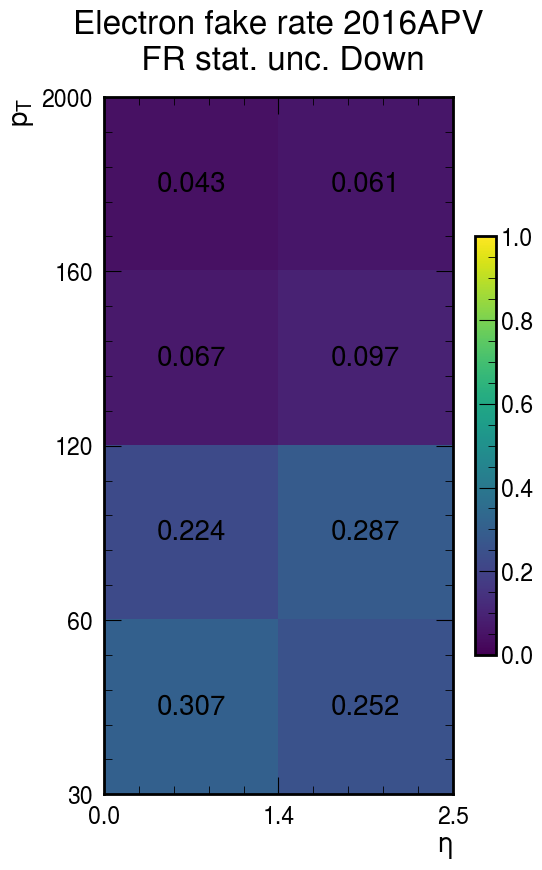

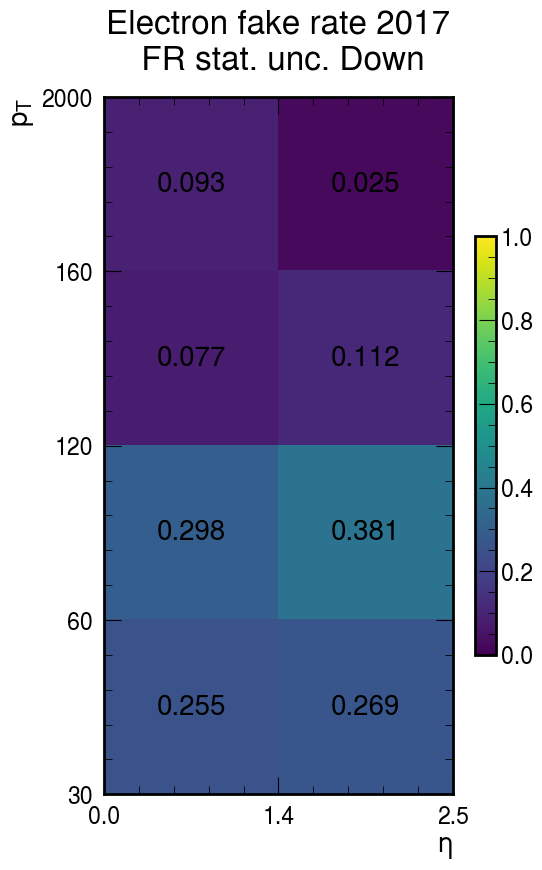

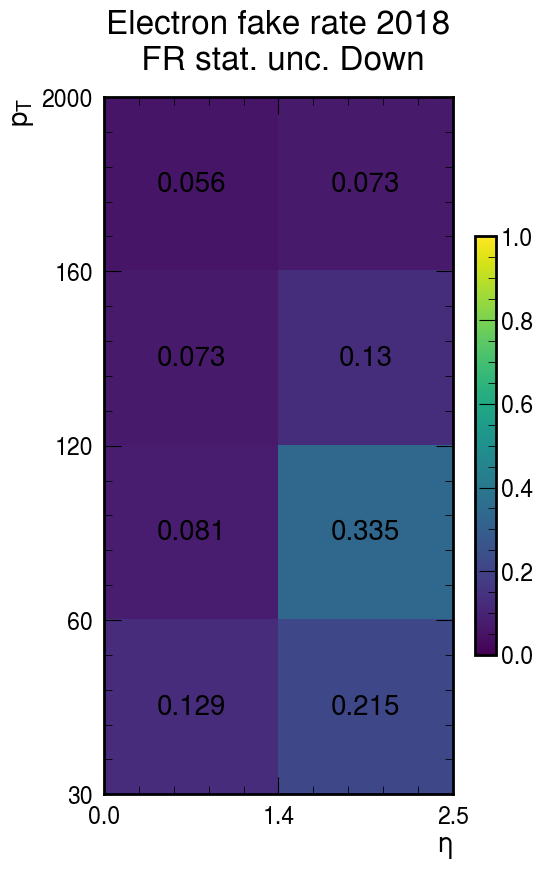

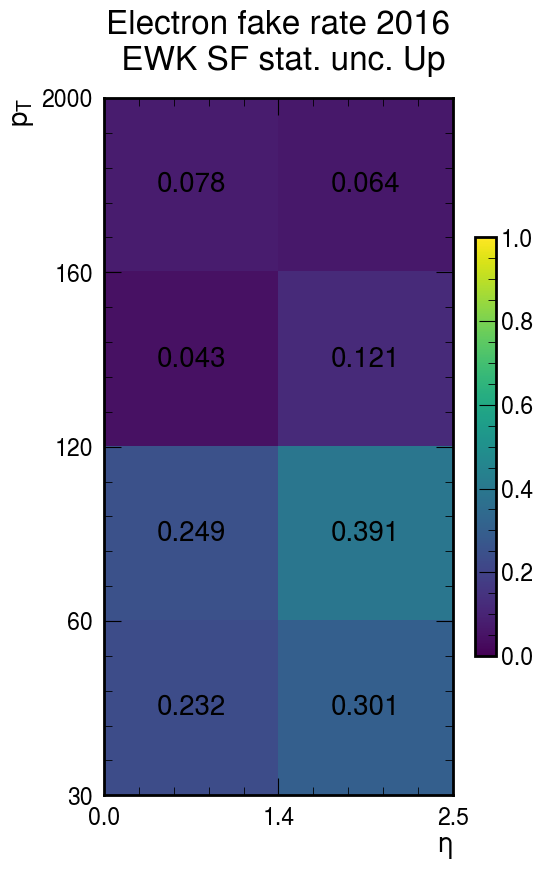

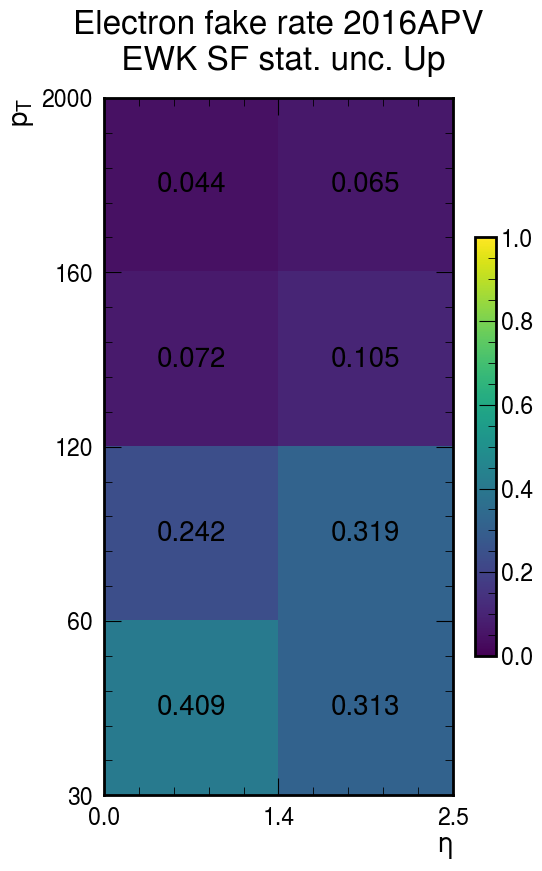

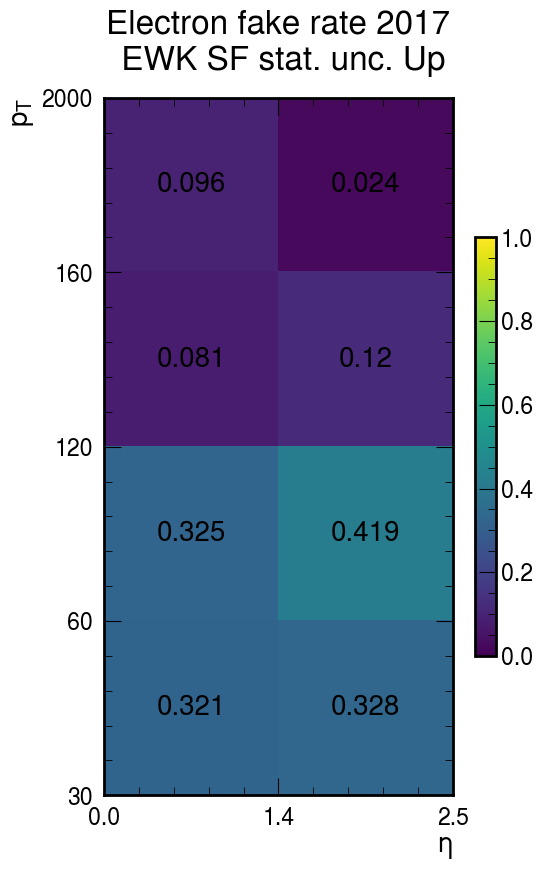

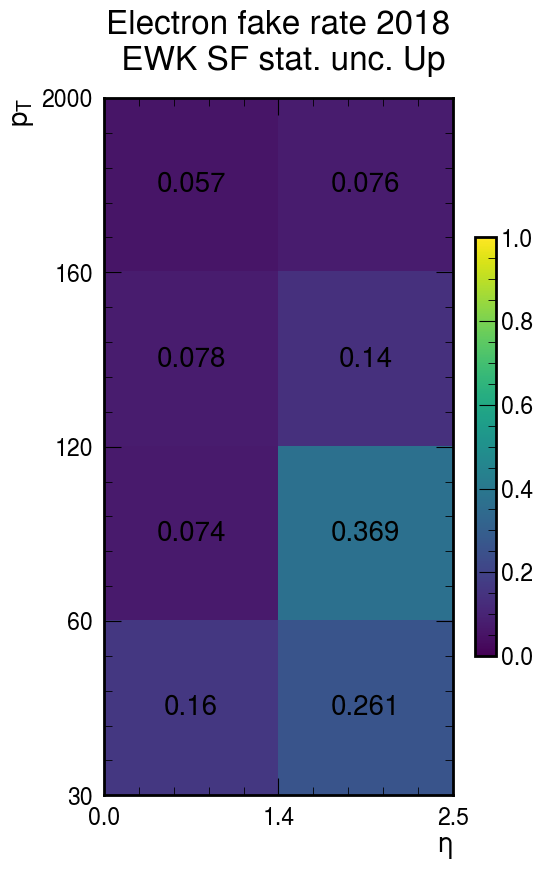

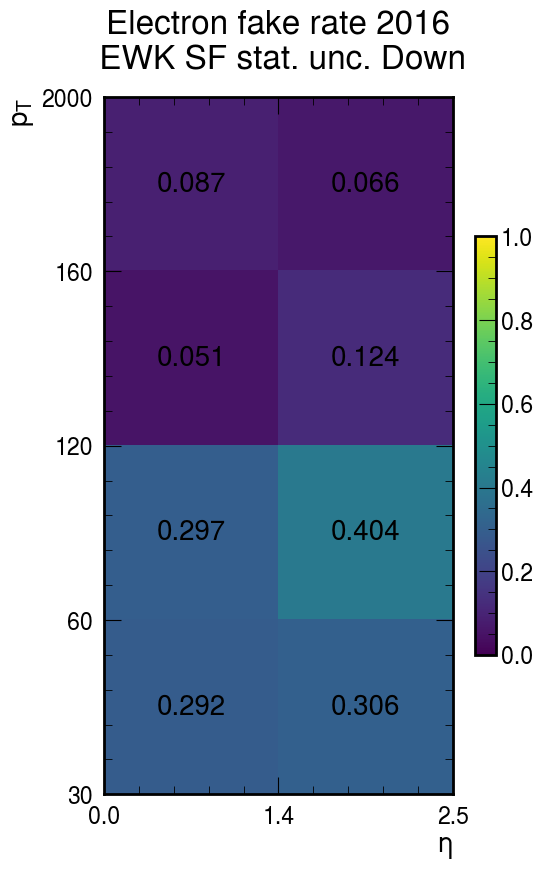

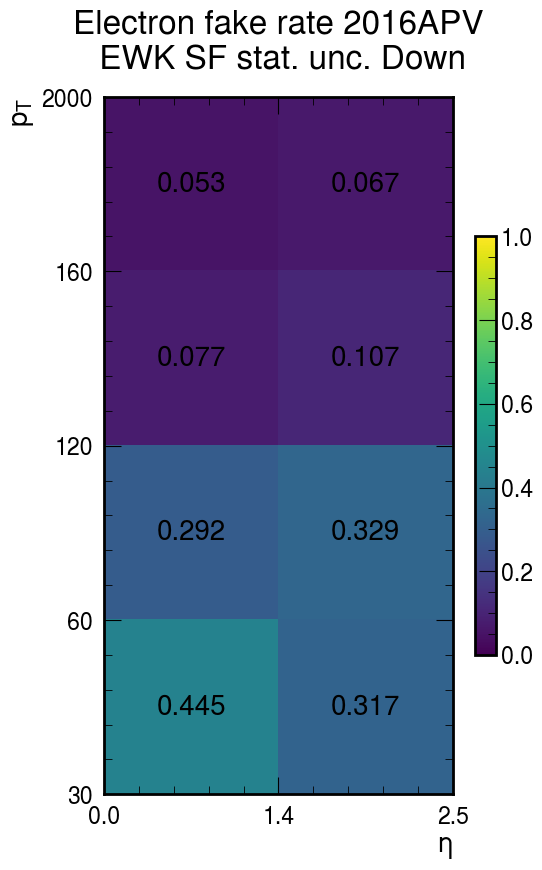

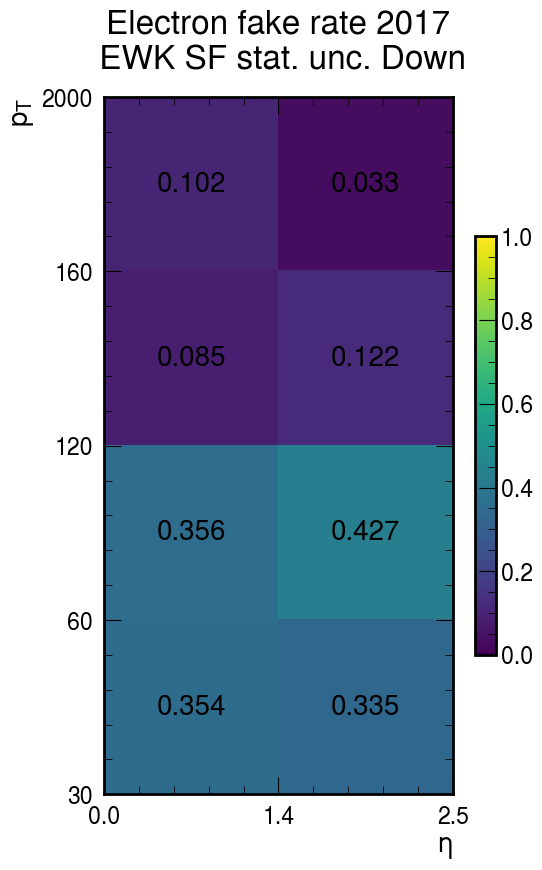

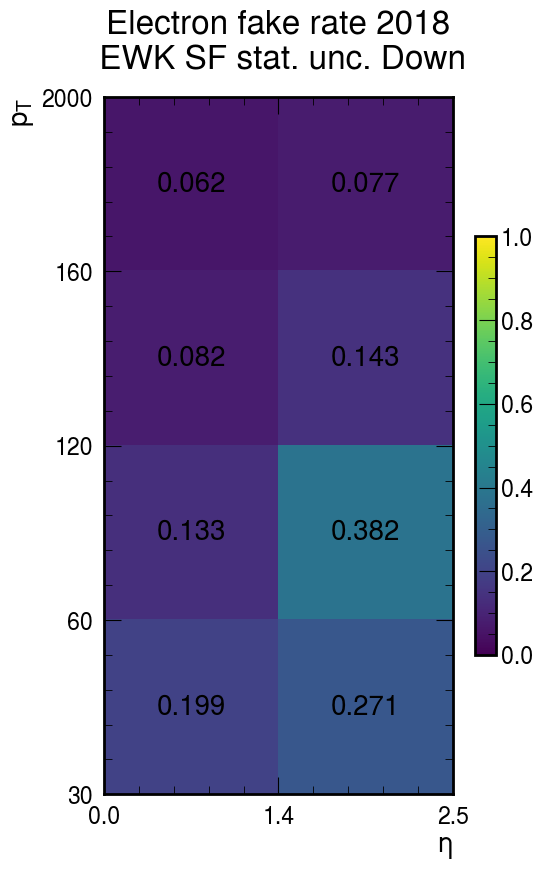

In [41]:
# plot_matrix(FR, region, channels, num=True)
# plot_matrix(FR, region, channels, den=True)
for variation in variations:
#     for year in ["2016"]:
    for year in years:        
        plot_matrix(FR[variation][year], region, channels, title=variation)
    #     plot_matrix(FR[year], region, channels, None)    

# Get fake contribution from FR

In [52]:
import scipy
def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [53]:
! ls /Users/fmokhtar/projects/boostedhiggs/eos/May31_hww_uselooselep_2017/

SingleElectron_Run2017B SingleElectron_Run2017D SingleElectron_Run2017F
SingleElectron_Run2017C SingleElectron_Run2017E


In [121]:
PR = {
    "2016": 0.774,
    "2016APV": 0.731,
    "2017": 0.796,
    "2018": 0.788,
}

# PR = {
#     "2016": 0.95,
#     "2016APV": 0.95,
#     "2017": 0.95,
#     "2018": 0.95,
# }


for year in years:
    for variation in variations:
#         indir = f"/Users/fmokhtar/projects/boostedhiggs/eos/May31_hww_uselooselep_{year}"
#         outdir = f"/Users/fmokhtar/projects/boostedhiggs/eos/June25_hww_{year}"
        
        indir = f"/Users/fmokhtar/projects/boostedhiggs/eos/July18_hww_uselooselep_{year}"
        outdir = f"/Users/fmokhtar/projects/boostedhiggs/eos/July18_hww_{year}"        

        ch = "ele"

        print(f"{year}, {ch} channel:")
        if ch == "ele":
            if year == "2018":
                l = glob.glob(f"{indir}/EGamma*/outfiles/*_{ch}.parquet")
            else:
                l = glob.glob(f"{indir}/SingleElectron*/outfiles/*_{ch}.parquet")

        else:
            l = glob.glob(f"{indir}/SingleMuon*/outfiles/*_{ch}.parquet")
        data = pd.read_parquet(l)

        data["THWW"] = get_finetuned_score(data, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")

        if ch == "ele":
            Nt0 = (data["n_tight_electrons"]==0)
            Nt1 = (data["n_tight_electrons"]==1)
        else:
            Nt0 = (data["n_tight_muons"]==0)
            Nt1 = (data["n_tight_muons"]==1)

        data["nominal"] = 1

        for i in range(len(ptbinning[ch])-1):
            high_pt = ptbinning[ch][i]
            low_pt = ptbinning[ch][i+1]

            msk_pt = (data["lep_pt"] >= low_pt) & (data["lep_pt"] < high_pt)

            for j in range(len(etabinning)-1):
                low_eta = etabinning[j]
                high_eta = etabinning[j+1]

                msk_eta = (abs(data["lep_eta"]) >= low_eta) & (abs(data["lep_eta"]) < high_eta)

                data["nominal"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])
                data["nominal"][msk_pt & msk_eta & Nt1] = (FR[variation][year][ch][i,j] * (PR[year]-1)) / (PR[year] - FR[variation][year][ch][i,j])

        data.to_parquet(f"{outdir}/fake_{year}_{ch}_{variation}.parquet")

2016, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09502823262287119' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.10603161433706895' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.08429661219680445' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0893908195863854' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.10082608935276323' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016APV, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.054247861789760626' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016APV, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06035415787332319' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016APV, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.04823507968968179' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016APV, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.04919731693885155' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2016APV, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.05930882939764064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2017, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.11595640692978439' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2017, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.12393140640532362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2017, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.10811849157443609' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2017, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.11220703544449623' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2017, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.11970969344839558' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2018, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0664471462453572' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2018, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.07078442611787435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2018, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.062153456973243176' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2018, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0638652369000136' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])


2018, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64587/581214960.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06903130820825105' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR[year] * FR[variation][year][ch][i,j]) / (PR[year] - FR[variation][year][ch][i,j])
